# An Improbable Afternoon

*This notebook first appeared as a [blog post](//betatim.github.io/posts/improbable-afternoon) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2016, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

Spend an afternoon understanding these seemingly magical algorithms.

This post covers a few probabilistic data structures in python. Each of them
deals with counting things in one form or another (how many unique items,
is an item present, how many of each have we seen, etc).

The idea behind these
probabilistic data structures is that you can use a lot less memory to
perform each task if you are happy to get an estimate instead of a precise
answer. At first this sounds like it would make your life more difficult,
but often it turns out to allow you to do things that were impossible
before.


## Call me, ... maybe

The theme tune you should be listening to for this post (because the Tour
starts in a few days):

In [1]:
from IPython.display import VimeoVideo
VimeoVideo(48756378)

## Old School Spellchecking

A famous example of using probabilistic data structures is the following:
How would you implement a (fast) spellchecker if there are more words in
your dictionary than you have RAM? In the early days of computers this
was the case. The slow solution is to search your on disk dictionary
for each word in the document. A faster solution is to be able to quickly
rule out words that are definitely not in the dictionary, and only going
to disk for the words you think might be in the dictionary. This is what
the [Bloom filter](#bloom-filter) was invented for.


## Contents

These four data structures are definitely covered in this post:

* Bloom filters ✔︎
* Count-min sketch ✔︎
* MinHash (not done yet)
* HyperLogLog ✔︎

**Word of warning:** I tried to keep the implementations as simple as
possible. The goal was to make it as easy to understand what was going
on as possible. There are several optimisations you can apply if you
want to use these at scale. Please find yourself a good, well tested
implementation somewhere else if you want to use these in production.

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [3]:
import random
random.seed(12345)
from collections import Counter
import string

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import murmurhash3_32
from sklearn.utils import check_random_state


# python's builtin hash function isn't even approximately random
def hash_(n, seed=1):
    return murmurhash3_32(n, seed=seed, positive=True)

## Do I know you?

The simplest form of keeping track of items you have seen is to create
a list to which you add each new item. The good news is that this is easy
to implement, you can check if you have seen `X` and answer the
question "What are all the items you have seen?". The bad news is that you need
to have enough memory to store each new, unique item.

Answering the question "Have I seen `X`
before?" does not require you to store every item you have seen though! Instead
you can use a list of `m` bits and some method to convert an item into
an index into that list. So when you see `X` you calculate the position
`i` in the list corresponding to the item and turn on the bit there.

To find out if you have seen `X` before you calculate the index `i` and
check if the bit there is turned on or off. Simplez.

> ### Hash functions

> How to turn an item into an index? A hash function. There are many different hash
> functions for many different tasks. One thing you can do with them is to "summarise"
> an item in a single number. For example `hash('hello world') -> 6355` and `hash('hello world!') -> 2359`.
> We can now use this number as our index.

The eagle-eyed will have spotted a caveat with this approach: What if
two different items `X` and `Y` end up producing the same index `i`? This
could happen either because their hash is the same or because we only have
`m` entries in our list.

This is why it is called a probabilistic data structure. We summarise items
and keep track of counts with a small number of bits. This means we might
make a mistake. In thise particular case you can see that increasing `m`
(for a given number of unique items) controls how likely you are to make
a mistake. If you make `m` very small you need hardly any memory and make
mistakes all the time. If you make `m` very large you will use as much
as if you stored every item and make nearly no mistakes.


## Multiple hashes

It turns out you can do better than using `m` bits and one hash function
without increasing the amount of memory you use. The trick is to use
`k` different hash functions which turn on bits in the same list of length
`m`. To check if an item has been seen you check if all `k` positions are
turned on. If one of them is off you know you did not see this item.

A simple way of understanding why this approach does better than using
one hash function is to think of each hash function as a member of a
crowd. The reason for the crowd of hash functions doing better than
a single one of them is the same why a crowd does better at estimating
the weight of a cow. You are averaging several independent estimates.


## The Bloom filter

This then is the `BloomFilter`: an array of `m` bits and `k` hash functions.
Membership testing without knowing who is a member! Sounds crazy, but
this does actually work.

In [4]:
class BloomFilter:
    def __init__(self, m, k, random_state=None):
        # k hash functions and m bits
        self.m = m
        self.rng = check_random_state(random_state)
        self.bits = np.zeros(m, dtype=bool)
        r = self.rng.randint(1e9)
        self.k = [r + k for k in range(1, k+1)]

    def add(self, val):
        for i in self.k:
            idx = hash_(val, i) % self.m
            self.bits[idx] = True

    def __contains__(self, val):
        for i in self.k:
            if not self.bits[hash_(val, i) % self.m]:
                return False
            
        return True
    
    def entries(self):
        """Approximate number of entries."""
        X = np.sum(self.bits)
        return -(self.m / float(len(self.k))) * np.log(1 - X/self.m)

Let's take it for a ride. We create a `BloomFilter` with a memory of 15000 bits
and 20 hash functions. Then fill it with 1000 random numbers. Afterwards we check
which fraction of the numbers we have seen previously is recognised by the
`BloomFilter`. We also check what fraction of previously unseen numbers
are incorrectly assumed to be a member.

In [5]:
b = BloomFilter(15000, 20)

def fill(B, n_test=1000, upper=1e9, exact=False):
    if exact:
        exact_ = set()

    for n in range(n_test):
        r = np.random.randint(upper)
        B.add(r)
        if exact:
            exact_.add(r)
            
    if exact:
        return exact_
    
exact = fill(b, exact=True)

n_true = 0
for e in exact:
    if e in b:
        n_true += 1

def fakes(B, n_test=1000, upper=1e9):
    n_fake = 0
    for e in np.random.randint(upper, size=n_test):
        if int(e) in B:
            n_fake += 1
            
    return n_fake / n_test
        
print('True positive rate: %.3f False positive rate: %.3f.' % (n_true / len(exact),
                                                               fakes(b)))

True positive rate: 1.000 False positive rate: 0.001.


Below a small illustration how the false positive rate changes
with the size of the bloom filter. As expected, the more memory
you allocate the smaller the false positive rate. For a given
size of bloom filter, the false positive rate gets worse as
the number of values stored increases. The legend shows the
true number of entries as well as the estimated number of
entries in brackets.

The second figure investigates the behaviour as a function
of the number of hash functions at fixed bloom filter size.

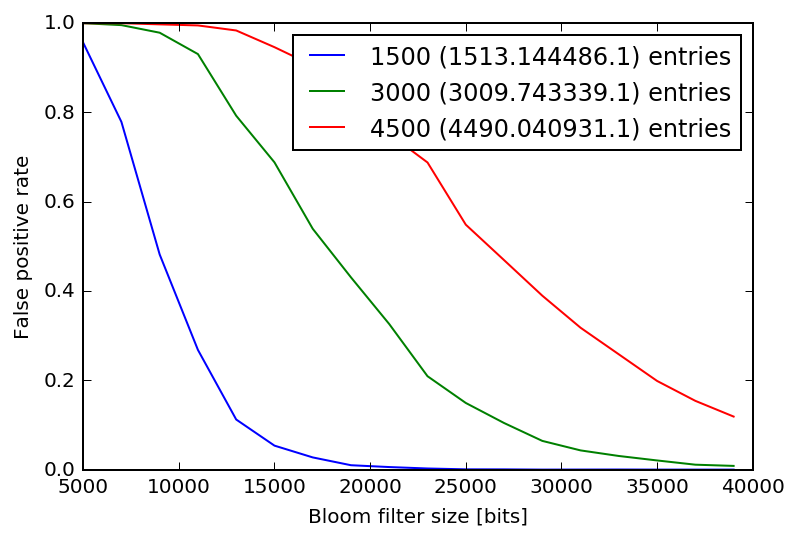

In [6]:
sizes = np.arange(5000, 40000, step=2000)

for n_test in (1500, 3000, 4500):
    fake_rate = []
    for size in sizes:
        b = BloomFilter(size, 20)
        fill(b, n_test=n_test)
        fake_rate.append(fakes(b, n_test=10000))

    plt.plot(sizes, fake_rate, label='%i (%f.1) entries' % (n_test, b.entries()))

plt.legend(loc='best')
plt.xlabel('Bloom filter size [bits]')
plt.ylabel('False positive rate')

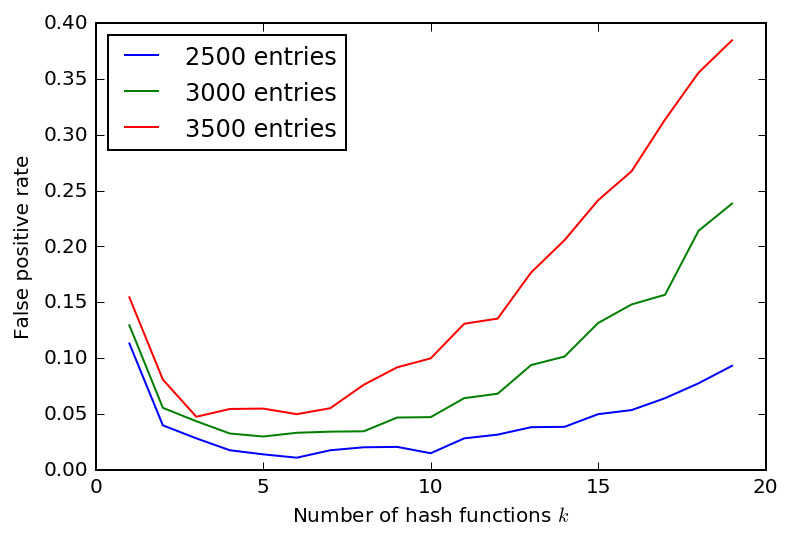

In [7]:
for n_test in (2500, 3000, 3500):
    hash_funs = np.arange(1, 20)
    fake_rate = []
    for k in hash_funs:
        b = BloomFilter(22000, k)
        fill(b, n_test=n_test)
        fake_rate.append(fakes(b, n_test=3000))

    plt.plot(hash_funs, fake_rate, label='%i entries' % n_test)

plt.legend(loc='best')
plt.xlabel('Number of hash functions $k$')
plt.ylabel('False positive rate')

## Count-Min Sketch

After this deep dive into bloom filters, let's move on to data structures
which use bloom filters as building blocks.

One thing you can not do with a standard bloom filter is count how
often you have seen an item. A [count-min sketch](https://en.wikipedia.org/wiki/Count%E2%80%93min_sketch) is similar to a bloom
filter, except it can estimate how often it has seen each item, not
just answer yes or no.

Instead of having just one array which you index with $k$ hash functions
you create $d$ arrays of size $w$, and index each with its own hash function.
To find the number of times you have seen an item you take the minimum count over
all arrays.

In [8]:
class CountMinSketch:
    def __init__(self, w, d, random_state=None):
        self.rng = check_random_state(random_state)
        self.w = w # cols
        self.d = d # rows
        
        self.k = self.rng.randint(1e9, size=d)
        self.t = np.zeros((d, w), dtype=np.int)
        self.N = 0
        self.hash_ = np.vectorize(hash_)

    def update(self, val):
        idx = self.hash_(val, self.k) % self.w
        self.t[np.arange(len(self.t)), idx] += 1
        self.N += 1

    def query(self, val):
        idx = self.hash_(val, self.k) % self.w
        return np.min(self.t[np.arange(len(self.t)), idx])

The code below stores 1000 unique words in a count min sketch with counts for
each word varying between zero and 50. Afterwards we print out the true and the
estimated counts.

In [9]:
cms = CountMinSketch(100, 300)

words = {}
for n in range(1000):
    word = ''.join([random.choice(string.ascii_lowercase) for _ in range(10)])
    count = np.random.randint(50)
    words[word] = count
    for _ in range(count):
        cms.update(word)

for n,word in enumerate(words):
    print(words[word], cms.query(word))
    if n > 20:
        break

5 64
49 113
31 92
46 92
1 65
35 61
38 57
15 38
17 70
1 49
14 19
8 12
45 70
15 16
44 96
17 83
14 62
10 48
44 71
10 40
12 64
38 110


## HyperLogLog

Next up: How many distinct items are there in a stream of data? The [HyperLogLog](https://en.wikipedia.org/wiki/HyperLogLog) (what a cool name!) can help you with that.

The implementation is a bit more involved. Mostly because you need to make a few
corrections for edge cases (few and very many items).

The intuitive explanation of how and why the HyperLogLog works goes like this: By keeping
track of the longest run of heads someone has flipped you can estimate how often
they must have flipped the coin. The more often someone flips a coin in a row, the
higher the probability for them to observe a long run of heads.



In [10]:
def binary(w):
    """Binary representation of w"""
    return bin(w)[2:]

def rho(bit_string):
    """Index of first 1 in bit_string"""
    for n,x in enumerate(reversed(bit_string)):
        if x == '1':
            return n+1
        
    return 32

def alpha(b):
    if not (4 <= b <= 16):
        raise ValueError("b=%d should be in range [4 : 16]" % b)

    if b == 4:
        return 0.673

    if b == 5:
        return 0.697

    if b == 6:
        return 0.709

    return 0.7213 / (1.0 + 1.079 / (1 << b))

def hyperloglog(items, b=4):
    """Approximate count of distinct elements in `items`"""
    m = 2**b
    registers = np.zeros(m)

    for item in items:
        bin_ = binary(hash_(item))
        idx = int(bin_[-b:], 2)
        val = bin_[:-b]
        registers[idx] = max(registers[idx], rho(val))
        
    z = sum(np.power(2, -reg) for reg in registers)
    
    E = alpha(b) * m**2 / z
    
    # correct for small values
    if E <= 2.5 * m:
        V = m - np.count_nonzero(registers)
        if V > 0:
            return m * np.log(m/float(V))
        else:
            return E
        
    # correct for very large values
    elif 1./30 * 2**32:
        return -2**32 * np.log(1 - E/2**32)
        
    return E

hyperloglog(['b', 'v', 'c'], b=6)

3.0725900279270824

In [11]:
# how many distinct elements in a stream of 100000
# random numbers?
hyperloglog((np.random.randint(0, int(1e9)) for i in range(100000)), b=8)

110827.1032635108

And with this, happy counting!


## Further reading

[Probabilistic DS for web analytics](https://highlyscalable.wordpress.com/2012/05/01/probabilistic-structures-web-analytics-data-mining/) contains a lot of good explanation of these algorithms, with pictures and
example use cases. As well as a post by Titus [Awesome big data algorithms](http://ivory.idyll.org/blog/2013-pycon-awesome-big-data-algorithms-talk.html).

## Health warning

Let me repeat the health warning from the beginning: please **do not** use these
implementations in your production code. Find a well tested, heavily used
implementation elsewhere. Or create one based on these. These data structures
are like crypto code: you think it is easy to roll your own but will
make lots of subtle mistakes that invalidate your work.


Get in touch on twitter @[betatim](//twitter.com/betatim) if you have questions or comments.